In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

import autokeras as ak

os.chdir("/home/pchabets/Dropbox/STRESS_INDEX/")

### Import clinical data 
#### (exact same split as in R scripts for tree-based models and elastic net)

In [2]:
train = pd.read_csv("scripts/VM/data/clinical_train_imputed.csv")
test = pd.read_csv("scripts/VM/data/clinical_test_imputed.csv")

#### Turn labels into 0's and 1's for train data only, as Boruta feature selection will based on train set only
non-remitted = 0, remitted = 1

In [3]:
#not_remitted = 0, remitted = 1

from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder() 
lbl.fit(train['Remitted_depression'])

LabelEncoder()

In [4]:
train['Remitted_depression'] = lbl.transform(train['Remitted_depression'])
test['Remitted_depression'] = lbl.transform(test['Remitted_depression'])

In [5]:
X_train = train.drop(['Remitted_depression'], inplace=False, axis=1)
y_train = train['Remitted_depression']

In [6]:
X_test = test.drop(['Remitted_depression'], inplace=False, axis=1)
y_test = test['Remitted_depression']

In [7]:
# store names for later
X_names = X_train.columns

#### Scale non-binary data with MinMax scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train.iloc[:,1:10]) #exclude binary predictor (sex)

MinMaxScaler()

In [9]:
#exclude binary predictor (sex)
X_train.iloc[:,1:10] = scaler.transform(X_train.iloc[:,1:10])
X_test.iloc[:,1:10] = scaler.transform(X_test.iloc[:,1:10])

In [10]:
# Convert back to dataframe
X_train = pd.DataFrame(data=X_train,columns=X_names) 
X_test = pd.DataFrame(data=X_test, columns=X_names)

### Creating the model

In [ ]:
# clf = ak.StructuredDataClassifier(overwrite=False, 
#                                   max_trials=100, 
#                                   objective='val_accuracy',
#                                   directory="scripts/VM/Python/output/autokeras"
#                                  )

In [ ]:
# # Feed the structured data classifier with training data.
# clf.fit(X_train, y_train, 
# #         epochs=10, 
#         validation_split=0.1)

In [15]:
# # Evaluate the best model with testing data.
# clf.evaluate(X_test, y_test) # these are the same results

5/5 [==============================] - 0s 9ms/step - loss: 0.6738 - accuracy: 0.6250


[0.6737502813339233, 0.625]

In [17]:
# from sklearn.metrics import classification_report,confusion_matrix
# print(classification_report(y_test,y_pred=predicted_y))
# print(confusion_matrix(y_test,predicted_y, normalize="pred"))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        79
           1       0.66      0.54      0.59        81

    accuracy                           0.62       160
   macro avg       0.63      0.63      0.62       160
weighted avg       0.63      0.62      0.62       160

[[0.60215054 0.34328358]
 [0.39784946 0.65671642]]


In [ ]:
# # Export as Keras model
# model = clf.export_model()

In [24]:
# model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 10)                0         
_________________________________________________________________
normalization (Normalization (None, 10)                21        
_________________________________________________________________
dense (Dense)                (None, 32)                352       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
classification_head_1 (Activ (None, 1)                 0     

### Save model 

In [ ]:
# try:
#     model.save("scripts/VM/Python/output/autokeras/model_autokeras_clinical", save_format="tf")
# except Exception:
#     model.save("scripts/VM/Python/output/autokeras/model_autokeras_clinical.h5")

### Load model for further plotting/analysis

In [11]:
loaded_model = tf.keras.models.load_model("scripts/VM/Python/output/autokeras/model_autokeras_clinical", 
                                          custom_objects=ak.CUSTOM_OBJECTS
                                         )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
# should have the same accuracy as clf -> check.
score = loaded_model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

5/5 [==============================] - 0s 6ms/step - loss: 0.6738 - accuracy: 0.6250
accuracy: 62.50%


### Model evaluation

In [13]:
# Predict with the best model.
predicted_y = loaded_model.predict(X_test)

In [14]:
# Turn predicted probabilities (between 0 and 1) to binary values (either 0 or 1)
predicted_y = [int(i > .5) for i in predicted_y]

### Plot ROC curve and calculate AUC

In [15]:
from sklearn.metrics import plot_roc_curve, roc_curve, auc, plot_confusion_matrix, confusion_matrix

In [16]:
y_pred_keras = loaded_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

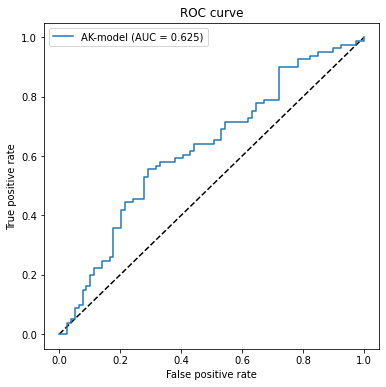

In [17]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AK-model (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Plot confusion matrix

In [18]:
cm = confusion_matrix(y_test, predicted_y, normalize="pred", labels=[0, 1])

In [19]:
#non-remitted = 0, remitted = 1
pd.DataFrame(cm)

,0,1
0,0.602151,0.343284
1,0.397849,0.656716


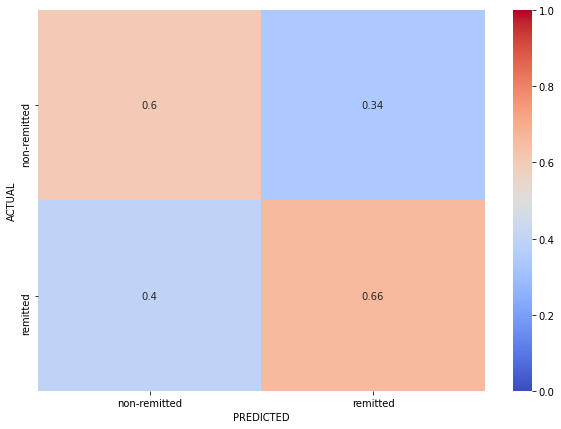

In [20]:
#Plot confusion matrix
import seaborn as sns
plt.figure(figsize = (10,7))
ax = plt.axes()
sns.heatmap(cm, 
            annot=True,
            vmin=0,
            vmax=1,
            cmap='coolwarm',
            xticklabels=['non-remitted', 'remitted'], 
            yticklabels=['non-remitted', 'remitted'])
ax.set(xlabel='PREDICTED', ylabel = 'ACTUAL')
sns.set(font_scale=1.8)

In [21]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score

print("Precision: {}".format(precision_score(y_test,predicted_y).round(2)))
print("Recall: {}".format(recall_score(y_test,predicted_y).round(2)))
print("F1 Score: {}".format(f1_score(y_test,predicted_y).round(2)))
print("Accuracy: {}".format(accuracy_score(y_test,predicted_y).round(3)))
print("Balanced accuracy: {}".format(balanced_accuracy_score(y_test,predicted_y).round(2)))

Precision: 0.66
Recall: 0.54
F1 Score: 0.59
Accuracy: 0.625
Balanced accuracy: 0.63


### Create confidence interval for AUC using DeLong's method
Original Code found in:
https://github.com/yandexdataschool/roc_comparison


In [22]:
import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [23]:
alpha = .95
y_pred = y_pred_keras
y_true = y_test.values.flatten()

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)


AUC: 0.6250976715111737
AUC COV: 0.0019742624291418723
95% AUC CI: [0.53801123 0.71218411]
